This notebook is an analysis of the errors in relative free energy calculations on the Schrödinger JACS dataset:
> Wang, L., Wu, Y., Deng, Y., Kim, B., Pierce, L., Krilov, G., ... & Romero, D. L. (2015). Accurate and reliable prediction of relative ligand binding potency in prospective drug discovery by way of a modern free-energy calculation protocol and force field. Journal of the American Chemical Society, 137(7), 2695-2703.

http://doi.org/10.1021/ja512751q

as reported in the AMBER TI chemRixv manuscript:

> Validation of AMBER/GAFF for Relative Free Energy Calculations
Preprint submitted on 02.02.2019, 15:29 and posted on 04.02.2019, 15:08 by Lin Song Tai-Sung Lee Chun Zhu Darrin M. York Kenneth M. Merz Jr.

https://chemrxiv.org/articles/Validation_of_AMBER_GAFF_for_Relative_Free_Energy_Calculations/7653434

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import sklearn.metrics
import scipy.stats

In [2]:
pd.options.display.float_format = '{:,.2f}'.format

def read_dataset():
    """Read the dataset
    
    Code from Pat Walters:
    https://github.com/PatWalters/FEP_TI_Comparison/blob/master/fep_ti_analysis.ipynb

    Returns
    -------
    master_df : pandas.Dataframe
       dataframe containing DeltaG values (kcal/mol) for all targets
    """
    def get_data_from_sheet(xls,sheet_name,col_names):
        df = xls.parse(sheet_name=sheet_name,header=None)
        df = df[df.columns[15:18]]
        df.columns = col_names
        df.dropna(inplace=True)
        df = df.query("EXP > -20")
        rows,_ = df.shape
        df.insert(0,"Target",[sheet_name]*rows)
        df.insert(1,"ID",[f"{sheet_name}_{x}" for x in range(0,rows)])
        return df

    xls = pd.ExcelFile("amber-ti/FEP_vs_GTI-dG-SI.xlsx")
    sheet_names = xls.sheet_names

    col_names = ["EXP","FEP","TI"]
    master_df = pd.DataFrame(columns=["Target","ID"]+col_names)
    for sheet in sheet_names:
        tmp_df = get_data_from_sheet(xls,sheet,col_names)
        master_df = master_df.append(tmp_df)   
    master_df.sort_values("Target",inplace=True)

    return master_df

df = read_dataset()

targets = df['Target'].unique()
print(targets)

df.head()

['bace' 'cdk2' 'jnk1' 'mcl1' 'p38a' 'ptp1b' 'thrombin' 'tyk2']


,Target,ID,EXP,FEP,TI
12,bace,bace_12,-8.53,-6.76,-8.27
30,bace,bace_30,-7.84,-7.40,-7.40
29,bace,bace_29,-9.01,-7.93,-7.80
28,bace,bace_28,-8.25,-7.01,-9.72
27,bace,bace_27,-9.10,-10.14,-10.16


In [3]:
def bootstrap_statistic(y_true, y_pred, ci=0.95, statistic='RMSE', nbootstrap = 1000, plot_type='dG'):
    """Compute mean and confidence intervals of specified statistic.
    
    Parameters
    ----------
    y_true : ndarray with shape (N,)
        True values
    y_pred : ndarray with shape (N,)
        Predicted values
    ci : float, optional, default=0.95
        Interval for CI
    statistic : str
        Statistic, one of ['RMSE', 'MUE', 'R2', 'rho']
    nbootstrap : int, optional, default=1000
        Number of bootstrap samples
    plot_type : str, optional, default='dG'
        'dG' or 'ddG'
        
    Returns
    -------
    rmse_stats : dict of floeat
        'mean' : mean RMSE
        'stderr' : standard error
        'low' : low end of CI
        'high' : high end of CI
    """
    
    def compute_statistic(y_true_sample, y_pred_sample, statistic):
        """Compute requested statistic.
        
        Parameters
        ----------
        y_true : ndarray with shape (N,)
            True values
        y_pred : ndarray with shape (N,)
            Predicted values
        statistic : str
            Statistic, one of ['RMSE', 'MUE', 'R2', 'rho']
            
        """
        if statistic == 'RMSE':
            return np.sqrt(sklearn.metrics.mean_squared_error(y_true_sample, y_pred_sample))
        elif statistic == 'MUE':
            return sklearn.metrics.mean_absolute_error(y_true_sample, y_pred_sample)
        elif statistic == 'R2':
            return sklearn.metrics.r2_score(y_true_sample, y_pred_sample)
        elif statistic == 'rho':
            return scipy.stats.pearsonr(y_true_sample, y_pred_sample)[0]
        else:
            raise Exception("unknown statistic '{}'".format(statistic))
            
    def unique_differences(x):
        """Compute all unique differences"""
        N = len(x)
        return np.array( [ (x[i] - x[j]) for i in range(N) for j in range(N) if (i != j) ] )        
            
    assert len(y_true) == len(y_pred)
    sample_size = len(y_true)
    s_n = np.zeros([nbootstrap], np.float64) # s_n[n] is the statistic computed for bootstrap sample n
    for replicate in range(nbootstrap):
        indices = np.random.choice(np.arange(sample_size), size=[sample_size])
        if plot_type == 'dG':
            y_true_sample, y_pred_sample = y_true[indices], y_pred[indices]
        elif plot_type == 'ddG':
            y_true_sample, y_pred_sample = unique_differences(y_true[indices]), unique_differences(y_pred[indices])
        s_n[replicate] = compute_statistic(y_true_sample, y_pred_sample, statistic)
                
    rmse_stats = dict()
    if plot_type == 'dG':
        rmse_stats['mean'] = compute_statistic(y_true, y_pred, statistic)
    elif plot_type == 'ddG':
        rmse_stats['mean'] = compute_statistic(unique_pairs(y_true), unique_pairs(y_pred), statistic)        
    rmse_stats['stderr'] = np.std(s_n)
    
    # TODO: Is there a canned method to do this?
    s_n = np.sort(s_n)
    low_frac = (1.0-ci)/2.0
    high_frac = 1.0 - low_frac
    rmse_stats['low'] = s_n[int(np.floor(nbootstrap*low_frac))]
    rmse_stats['high'] = s_n[int(np.ceil(nbootstrap*high_frac))]

    return rmse_stats

In [4]:
def compute_ddGs(df):
    """Construct a new dataframe with ddGs for all ligand pairs within each target.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The master dG dataframe
        
    Returns
    -------
    ddG_df : pandas.DataFrame
        A new dataframe containing all ddGs within each target
        
    """
    ddG_df = pd.DataFrame(columns=['Target', 'ID1', 'ID2', 'EXP', 'FEP', 'TI'])
    index = 0
    for target, rows in df.groupby("Target"):
        for i, row_i in rows.iterrows():
            for j, row_j in rows.iterrows():
                if i != j:                
                    ddG_df.loc[index] = [
                        target, row_i['ID'], row_j['ID'], 
                        row_j['EXP'] - row_i['EXP'], 
                        row_j['FEP'] - row_i['FEP'], 
                        row_j['TI'] - row_i['TI']
                    ]
                    index += 1
    return ddG_df

# Plot data by system
def plot_data(rows, title, plot_type='dG'):
    """
    Plot predicted vs experimental ddG for FEP+ and AMBER TI.
    
    Parameters
    ----------
    title : str
        Plot title
    rows : pd.Dataframe
        Pandas dataframe containing 'EXP', 'FEP', and 'TI' columns
    plot_type : str
        Either 'dG' or 'ddG'
        
    """
    if plot_type == 'ddG':
        # Compute all unique differences
        rows = compute_ddGs(rows)       
    
    nsamples = len(rows['EXP'].values)
    methods = ('EXP', 'FEP', 'TI')
    xmin = min([rows[method].values.min() for method in methods])
    xmax = max([rows[method].values.max() for method in methods])
    if plot_type == 'ddG':        
        xmax = + (max(abs(xmin), abs(xmax)) + 0.5)
        xmin = - xmax
        plt.xlabel('experiment $\Delta \Delta G$ (kcal/mol)');
        plt.ylabel('predicted $\Delta \Delta G$ (kcal/mol)');
    elif plot_type == 'dG':
        plt.xlabel('experiment $\Delta G$ (kcal/mol)');
        plt.ylabel('predicted $\Delta G$ (kcal/mol)');
    else:
        raise ValueError('Unknown plot type {}'.format(plot_type))

    plt.plot([xmin, xmax], [xmin, xmax], 'b-');
    plt.plot([0, 0], [xmin, xmax], 'k:');
    plt.plot([xmin, xmax], [0, 0], 'k:');
    hFEP = plt.plot(rows['EXP'].values, rows['FEP'].values, 'k.');
    hTI = plt.plot(rows['EXP'].values, rows['TI'].values, 'r.');
    plt.legend([hFEP[0], hTI[0]], ['OPLS3', 'GAFF'])

    # Compute error statistics
    stats = { 
        (method,statistic) : bootstrap_statistic(rows['EXP'].values, rows[method].values, statistic=statistic) 
        for method in ('FEP', 'TI') 
        for statistic in ('RMSE', 'MUE', 'R2', 'rho') 
    }
    
    # Label plot with error statistics
    title = """{} (N = {})
    RMSE: OPLS3    {:5.2f} [95%: {:5.2f}, {:5.2f}] kcal/mol
    RMSE: GAFF     {:5.2f} [95%: {:5.2f}, {:5.2f}] kcal/mol
    MUE : OPLS3    {:5.2f} [95%: {:5.2f}, {:5.2f}] kcal/mol
    MUE : GAFF     {:5.2f} [95%: {:5.2f}, {:5.2f}] kcal/mol
    R2  : OPLS3    {:5.2f} [95%: {:5.2f}, {:5.2f}] kcal/mol
    R2  : GAFF     {:5.2f} [95%: {:5.2f}, {:5.2f}] kcal/mol
    rho : OPLS3    {:5.2f} [95%: {:5.2f}, {:5.2f}] kcal/mol
    rho : GAFF     {:5.2f} [95%: {:5.2f}, {:5.2f}] kcal/mol
    """.format(title, nsamples,
               stats[('FEP','RMSE')]['mean'], stats[('FEP','RMSE')]['low'], stats[('FEP','RMSE')]['high'],
               stats[('TI','RMSE')]['mean'], stats[('TI','RMSE')]['low'], stats[('TI','RMSE')]['high'],
               stats[('FEP','MUE')]['mean'], stats[('FEP','MUE')]['low'], stats[('FEP','MUE')]['high'],
               stats[('TI','MUE')]['mean'], stats[('TI','MUE')]['low'], stats[('TI','MUE')]['high'],
               stats[('FEP','R2')]['mean'], stats[('FEP','R2')]['low'], stats[('FEP','R2')]['high'],
               stats[('TI','R2')]['mean'], stats[('TI','R2')]['low'], stats[('TI','R2')]['high'],
               stats[('FEP','rho')]['mean'], stats[('FEP','rho')]['low'], stats[('FEP','rho')]['high'],
               stats[('TI','rho')]['mean'], stats[('TI','rho')]['low'], stats[('TI','rho')]['high'],
               )
    plt.title(title, fontsize=11, loc='right', horizontalalignment='right', family='monospace');
    
    plt.axis('square');
    plt.xlim(xmin, xmax);
    plt.ylim(xmin, xmax);

bace
cdk2
jnk1
mcl1
p38a
ptp1b
thrombin
tyk2


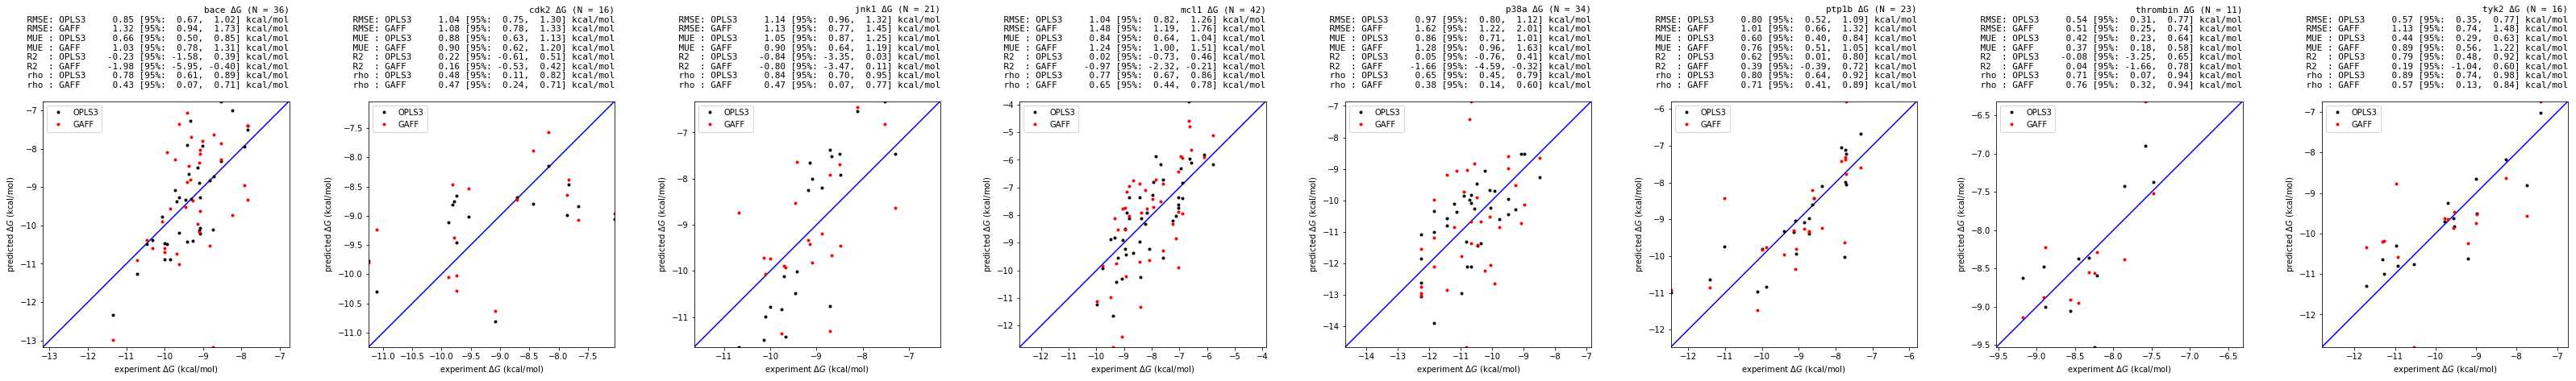

In [5]:
# Plot dG
ny = 1
nx = len(targets)
fig = plt.figure(figsize=[45,7])
plot_index = 1
for target, rows in df.groupby("Target"):   
    print(target)
    plt.subplot(ny, nx, plot_index)
    plot_data(rows, target + ' ΔG', plot_type='dG')
    plot_index += 1

# Write out figure to a file
fig.tight_layout()
fig.savefig('fepplus-vs-ti-dG.pdf');

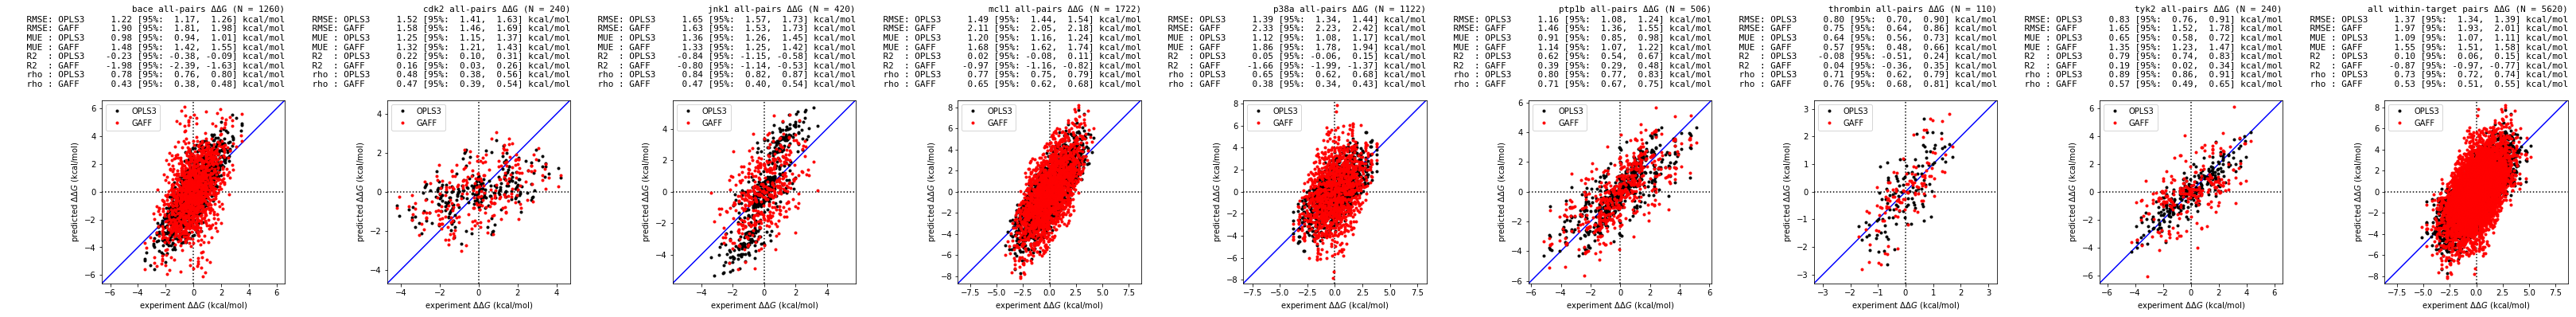

In [6]:
# Plot ddG between all ligand pairs
ny = 1
nx = len(targets)+1
fig = plt.figure(figsize=[45,7])
plot_index = 1
for target, rows in df.groupby("Target"):   
    plt.subplot(ny, nx, plot_index)
    plot_data(rows, target + ' all-pairs ΔΔG', plot_type='ddG')
    plot_index += 1
    
# Plot analysis of all ddG data
plt.subplot(ny, nx, len(targets)+1)
system = 'all'
plot_data(df, 'all within-target pairs ΔΔG', plot_type ='ddG')

# Write out figure to a file
fig.tight_layout()
fig.savefig('fepplus-vs-ti-allpairs-ddG.pdf');

In [7]:
fig.savefig('fepplus-vs-ti-allpairs-ddG.png', dpi=300);